<a id='toc'></a>
# Список тестов по запланированным локомотивам:

1. [Вычисление процента подвязки поездов и локомотивов.](#perc)
2. [Проверка правильности назначениях тяговых плеч локомотивам во входных данных.](#regions)
   1. [Проверка назначения тяговых плеч локомотивам в соответствии с сериями](#correct_reg_ser)
   2. [Проверка невыезда локомотива за пределы своих тяговых плеч в процессе планирования](#correct_reg_plan)
   3. [Локомотивы на чужих тяговых плечах на начало планирования](#bad_regs_loco_info)
3. [Проверка пунктов проведения ТО-2.](#st_to2)
4. [Проверка подвязки на соответствие весовым нормам.](#tonnage)
5. [Проверка смен локомотива на станциях обязательной смены.](#change)
6. [Анализ локомотивов резервом.](#res)
   1. [Проверка номеров поездов, соответствующих локомотивам резервом.](#res_nums)
   2. [Вычисление количества локомотивов резервом по направлениям.](#res_amount)
   3. [Проверка отправления локомотивов резервом до начала планирования.](#res_before)
   4. [Анализ отправления локомотивов резервом в четную сторону.](#res_even)
   5. [Проверка времени хода для локомотивов резервом](#Проверка-времени-хода-для-локомотивов-резервом)
7. [Проверка скачков по времени назад](#time_leaps)
7. [Создание отчета](#report)

### Константы и настройки

In [44]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

### Функции для экспорта в HTML

In [45]:
def add_line(line, p=PRINT):    
    global report        
    if p:        
        if type(line) == str:
            print(line)        
        elif type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:                
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report    
    report += ('<h%d>%s</h%d>' % (h, header, h))    
    if p:
        print(header)
        
def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="40%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>
                <h1>Проверки по локомотивам</h1>        
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован за %.2f сек. и записан в файл %s' % (time.time() - start_time, filename))

## Загрузка и подготовка данных

In [180]:
TIME_FORMAT = '%b %d, %H:%M'
'''
    Преобразует время из timestamp в красивый формат, заданный в константе time_format
'''
def nice_time(t):
    return time.strftime(TIME_FORMAT, time.localtime(t)) if t > 0 else ''

def nice_print(s, **kwargs):    
    num = kwargs['num'] if 'num' in kwargs.keys() else False
    cols = kwargs['cols'] if 'cols' in kwargs.keys() else s.columns
    if num:
        print(s.reset_index()[cols].to_string())
    else:
        print(s[cols].to_string(index=False))

In [46]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import get_ipython

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)
pd.set_option('display.max_colwidth', 25)

time_format = '%b %d, %H:%M'

start_time = time.time()
current_time   = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr            = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'team_work_region':str})
links          = pd.read_csv(FOLDER + 'link.csv', converters={'st_from':str, 'st_to':str})
stations       = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info     = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str})
train_plan     = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info      = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str, 
                                                                   'st_from':str, 'st_to':str, 'depot':str})
loco_plan      = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info      = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                     'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})

team_plan      = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series    = pd.read_csv(FOLDER + 'loco_series.csv')
loco_info_regs = pd.read_csv(FOLDER + 'loco_info_regs.csv', converters={'loco':str})
loco_tonnage   = pd.read_csv(FOLDER + 'loco_tonnage.csv', converters={'st_from':str, 'st_to':str})

st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
team_info.regions = team_info.regions.apply(literal_eval)

print('Время составления отчета:', time.strftime(time_format, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (time.strftime(time_format, time.localtime(current_time)), current_time))

Время составления отчета: Aug 01, 12:44
Время запуска планировщика: Jul 15, 14:41 (1468582897)


In [47]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_norm'] = df.time_start.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'time_end' in df.columns:
        df['time_end_norm'] = df.time_end.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')

In [48]:
# Добавляем ссылку на бригаду в таблицу локомотивов
# Добавляем ссылку на локомотив и бригаду в таблицу поездов

loco_plan['loco_time'] = list(zip(loco_plan.loco , loco_plan.time_start))
team_plan['loco_time'] = list(zip(team_plan.loco , team_plan.time_start))
loco_plan['team'] = loco_plan.loco_time.map(team_plan.drop_duplicates('loco_time').set_index('loco_time').team)

loco_plan['train_time'] = list(zip(loco_plan.train, loco_plan.time_start))
train_plan['train_time'] = list(zip(train_plan.train, train_plan.time_start))
train_plan['loco'] = train_plan.train_time.map(loco_plan.drop_duplicates('train_time').set_index('train_time').loco)
train_plan['team'] = train_plan.train_time.map(loco_plan.drop_duplicates('train_time').set_index('train_time').team)

add_info(loco_tonnage)
loco_tonnage['link'] = list(zip(loco_tonnage.st_from, loco_tonnage.st_to))
loco_tonnage['ssl'] = list(zip(loco_tonnage.series, loco_tonnage.sections, loco_tonnage.link))
loco_tonnage['ser_name'] = loco_tonnage.series.map(loco_series.set_index('ser_id').ser_name)

<a =id='perc'></a>
## Вычисление процента подвязки поездов и локомотивов [ToC](#toc)

In [49]:
def count_assign_percent(horizon):
    mask = (train_plan.time_start < current_time + horizon)
    bad_trains = train_plan.loc[mask & (train_plan.loco.isnull())]
    bad_trains_n = bad_trains.drop_duplicates('train').train.count()
    good_percent = 100 * (1 - bad_trains_n / total_trains_n)        
    return 'Процент подвязки поездов и локомотивов на горизонте в %2.d часов: %.2f%% (поездов без локомотива - %d)'\
         % (horizon / 3600, good_percent, bad_trains_n)

train_plan['train_type'] = train_plan.train.apply(lambda x: int(str(x)[0]))
total_trains_n = train_plan[train_plan.train_type.isin([2, 9])].drop_duplicates('train').train.count()
add_header('Вычисление процента подвязки поездов и локомотивов', p=False, h=2)
add_line(count_assign_percent(6 * 3600))
add_line(count_assign_percent(12 * 3600))
add_line(count_assign_percent(24 * 3600))
add_line(count_assign_percent(48 * 3600))

Процент подвязки поездов и локомотивов на горизонте в  6 часов: 83.85% (поездов без локомотива - 755)
Процент подвязки поездов и локомотивов на горизонте в 12 часов: 76.55% (поездов без локомотива - 1096)
Процент подвязки поездов и локомотивов на горизонте в 24 часов: 64.53% (поездов без локомотива - 1658)
Процент подвязки поездов и локомотивов на горизонте в 48 часов: 50.51% (поездов без локомотива - 2313)


In [51]:
a = train_plan[(train_plan.time_start < current_time + 24 * 3600) & (train_plan.loco.isnull())]\
    .drop_duplicates('train')\
    .groupby(['st_from_name', 'st_to_name']).train\
    .count().sort_values(ascending=False)
add_header('Направления, на которые не удалось подвязать локомотив под поезд (первые 10 по количеству поездов):')
add_line(a.head(10))
a.to_csv('a.csv')

Направления, на которые не удалось подвязать локомотив под поезд (первые 10 по количеству поездов):
st_from_name           st_to_name         
ХАБАРОВСК II           ХАБАРОВСК I            75
КАРЫМСКАЯ              ТАРСКАЯ                73
                       ЧИТА I                 57
МАРИИНСК               БОГОТОЛ                54
ХАБАРОВСК II           КРУГЛИКОВО             40
КРАСНОЯРСК-ВОСТОЧНЫЙ   КРАСНОЯРСК-СЕВЕРНЫЙ    36
ТАЙШЕТ                 ЮРТЫ                   33
СМОЛЯНИНОВО            НОВОНЕЖИНО             32
НАХОДКА-ВОСТОЧНАЯ      ХМЫЛОВСКИЙ             31
ИРКУТСК-СОРТИРОВОЧНЫЙ  ГОНЧАРОВО              29


In [52]:
(st_name, st2_name) = a.index[0]
train_cols = ['train', 'weight', 'st_from_name', 'st_to_name', 'st_dest_name', 'time_start_norm', 'time_end_norm', 'loco', 'team']
cols = ['train', 'weight', 'st_from_name', 'st_to_name', 'st_dest_name', 'time_start_norm', 'loco', 'ser_name', 'sections']
routes = pd.read_csv(FOLDER + 'routes.csv', converters={'st_from':str, 'st_to':str, 'train':str})
add_info(routes)
routes['end'] = routes.train != routes.train.shift(-1)
train_plan['st_dest_name'] = train_plan.train.map(routes[routes.end].set_index('train').st_to_name)
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
train_plan['ser_name'] = train_plan.loco.map(loco_info.set_index('loco').ser_name)
train_plan['sections'] = train_plan.loco.map(loco_info.set_index('loco').sections)
a = train_plan[(train_plan.time_start < current_time + 24 * 3600) 
               & (train_plan.loco.isnull())
               & (train_plan.st_dest_name.isnull() == False)
               & (train_plan.st_from_name == st_name)].drop_duplicates('train')
add_header('Поезда со станции %s, к которым не были подвязаны локомотивы' % st_name)
add_line(a.sort_values('time_start')[cols])

Поезда со станции ХАБАРОВСК II, к которым не были подвязаны локомотивы
        train  weight  st_from_name   st_to_name           st_dest_name time_start_norm loco ser_name  sections
 200021960281    1956  ХАБАРОВСК II  ХАБАРОВСК I        ПОСТ-ПОКРОВСКИЙ   Jul 15, 10:27  NaN      NaN       NaN
 200021657781    1687  ХАБАРОВСК II  ХАБАРОВСК I  ИРКУТСК-СОРТИРОВОЧНЫЙ   Jul 15, 16:00  NaN      NaN       NaN
 210218415837    5979  ХАБАРОВСК II   КРУГЛИКОВО      НАХОДКА-ВОСТОЧНАЯ   Jul 15, 16:30  NaN      NaN       NaN
 200021570413    1702  ХАБАРОВСК II  ХАБАРОВСК I   КРАСНОЯРСК-ВОСТОЧНЫЙ   Jul 15, 16:35  NaN      NaN       NaN
 200020313623    5433  ХАБАРОВСК II   КРУГЛИКОВО      НАХОДКА-ВОСТОЧНАЯ   Jul 15, 16:45  NaN      NaN       NaN
 200021719989    2499  ХАБАРОВСК II  ХАБАРОВСК I               МАРИИНСК   Jul 15, 16:45  NaN      NaN       NaN
 200021958280    1170  ХАБАРОВСК II  ХАБАРОВСК I            ХАБАРОВСК I   Jul 15, 16:55  NaN      NaN       NaN
 200021999452    5468  ХАБАРОВСК 

In [190]:
loco_info['is_planned'] = loco_info.loco.isin(loco_plan[loco_plan.state == 1].loco)
loco_info['oper_time_f'] = loco_info.oper_time.apply(nice_time)
info_cols = ['loco', 'ltype', 'oper_time_f', 'loc_name', 'tts', 'dts', 'is_planned']
no_plan = loco_info[(loco_info.loc_name == st_name) & (loco_info.is_planned == False) & (loco_info.ltype == 1)]
add_header('На станции %s находилось %d локомотивов, которые не были подвязаны ни к одному поезду:' 
           % (st_name, no_plan.loco.count()))
add_line(no_plan[info_cols])

На станции ХАБАРОВСК II находилось 30 локомотивов, которые не были подвязаны ни к одному поезду:
         loco  ltype    oper_time_f      loc_name     tts     dts is_planned
 200200076802      1  Jul 15, 12:55  ХАБАРОВСК II  158400    1141      False
 200200066277      1  Jul 15, 14:44  ХАБАРОВСК II  345600   10555      False
 200200029331      1  Jul 15, 13:10  ХАБАРОВСК II  475200   31443      False
 200200082113      1  Jul 15, 12:28  ХАБАРОВСК II  424800    3998      False
 200200096248      1  Jul 15, 07:59  ХАБАРОВСК II  432000   24754      False
 200200102407      1  Jul 14, 23:53  ХАБАРОВСК II  432000   26926      False
 200200102790      1  Jul 15, 09:34  ХАБАРОВСК II  424800   25343      False
 200200097316      1  Jul 15, 14:45  ХАБАРОВСК II  133200  999999      False
 200200097540      1  Jul 15, 14:18  ХАБАРОВСК II  403200  999999      False
 200200058350      1  Jul 15, 14:23  ХАБАРОВСК II  432000    4000      False
 200200082340      1  Jul 15, 14:46  ХАБАРОВСК II  42480

<a =id='regions'></a>
## Проверка наличия локомотивов только на своих тяговых плечах [ToC](#toc)

In [53]:
add_header('Проверка наличия локомотивов только на своих тяговых плечах', h=2, p=False)

<a id='correct_reg_ser'></a>
### Проверка назначения тяговых плеч локомотивам в соответствии с сериями [ToC](#toc)

In [54]:
add_header('Проверка назначения тяговых плеч локомотивам в соответствии с сериями', h=3, p=False)

In [55]:
def func(df, stations, st):    
    a = links.loc[(links.st_from_name.isin(st))].st_from_name.value_counts()
    b = links.loc[(links.st_from_name.isin(st)) & (links.st_to_name.isin(st))].st_from_name.value_counts()
    c = a.to_frame().join(b, rsuffix='_reg')
    c['delta'] = c.st_from_name - c.st_from_name_reg    
    d = c.join(stations[['name', 'norm_time']].drop_duplicates().set_index('name'), how='right')
    e = d.loc[((d.delta > 0) | (d.st_from_name == 1))]
    return sorted(e.index.values)

add_info(links)
loco_info['regions_eval'] = loco_info.regions.apply(literal_eval)
stations_regs = stations.groupby('station').loco_region.apply(lambda x: x.values)
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
reg_st = stations.groupby('loco_region')['name'].unique().to_frame()
reg_st['short_name'] = reg_st['name'].apply(lambda x: func(links, stations, x))
reg_st.columns = ['stations', 'reg_name']
reg_borders = pd.read_csv(FOLDER + 'mandatory/loco_reg_borders.csv', encoding='utf-8-sig')
bord = reg_borders.station.values
reg_st['short_name'] = reg_st.reg_name.apply(lambda x: np.intersect1d(x, bord) if len(np.intersect1d(x, bord)) > 1 else [])
big_borders = ['МАРИИНСК', 'БОРЗЯ', 'КАРЫМСКАЯ', 'ХАБАРОВСК II', 'МЕЖДУРЕЧЕНСК', 'ТАКСИМО', 'КОМСОМОЛЬСК-НА-АМУРЕ']
reg_st['short_name'] = reg_st.short_name.apply(lambda x: np.intersect1d(x, big_borders) if len(x) > 2 else x)
pd.set_option('display.max_colwidth', 60)
#print(reg_st[['short_name']].to_string())
#reg_st.ix[2002119307].reg_name

In [56]:
def save_to_excel(df, filename=FOLDER + 'reg_ser.xlsx'):    
    df.to_excel(filename)
    print('Excel file %s created' % filename)

loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
loco_info['ser_desc'] = loco_info.series.map(loco_series.set_index('ser_id').ser_desc)
loco_info['ser_type'] = loco_info.series.map(loco_series.set_index('ser_id').ser_type)
loco_info_regs['number'] = loco_info.loco.map(loco_info.drop_duplicates('loco').set_index('loco').number)
loco_info_regs['reg_name'] = loco_info_regs.region.map(reg_st.short_name)
loco_info_regs['ser_name'] = loco_info_regs.loco.map(loco_info.set_index('loco').ser_name)
loco_info_regs['ser_type'] = loco_info_regs.loco.map(loco_info.set_index('loco').ser_type)
loco_info_regs['reg_name_str'] = loco_info_regs.reg_name.apply(str)
loco_info_regs['ltype'] = loco_info_regs.loco.map(loco_info.set_index('loco').ltype)
loco_info_regs.sort_values(['ser_name', 'reg_name_str'])[['loco', 'ser_name', 'reg_name']].set_index('loco')\
                .to_excel(FOLDER + 'ans.xlsx')
a = loco_info_regs.groupby('reg_name_str').ser_name.unique()
loco_info_regs['ser_desc'] = loco_info_regs.ser_name.map(loco_series.drop_duplicates('ser_name').set_index('ser_name').ser_desc)
a = loco_info_regs.loc[(loco_info_regs.ltype == 1) & (loco_info_regs.ser_desc.isin(['Грузовое', 'Грузопассажирское']))]\
            .groupby(['region', 'reg_name_str']).ser_name.unique().to_frame()
b = loco_info_regs.loc[(loco_info_regs.ltype == 1) & (loco_info_regs.ser_desc.isin(['Грузовое', 'Грузопассажирское']))]\
            .groupby(['region', 'reg_name_str']).ser_type.unique().to_frame()
c = a.join(b)
d = c.join(loco_info_regs.loc[loco_info_regs.ltype == 1].groupby(['region', 'reg_name_str']).loco.count())
#print('Total locos:', loco_info.loco.drop_duplicates().count())
#print('Freight locos:', loco_info.loc[loco_info.ser_desc.isin(['Грузовое', 'Грузопассажирское'])].loco.drop_duplicates().count())
#print('Locos of type = 1:', loco_info[loco_info.ltype == 1].loco.drop_duplicates().count())
pd.set_option('display.max_colwidth', 40)
add_line(d.reset_index().sort_values('loco', ascending=False))
#save_to_excel(d)

     region                             reg_name_str                                 ser_name      ser_type  loco
 2002119299                     ['БОРЗЯ' 'МАРИИНСК']  [ВЛ85, ВЛ80Р, ВЛ80С, 2ЭС5К, 3ЭС5К, В...  [Электровоз]   651
 2002119294             ['КАРЫМСКАЯ' 'ХАБАРОВСК II']                    [3ЭС5К, ВЛ80С, 2ЭС5К]  [Электровоз]   560
 2002119320           ['СМОЛЯНИНОВО' 'ХАБАРОВСК II']                    [3ЭС5К, 2ЭС5К, ВЛ80С]  [Электровоз]   235
 2002119301               ['МЕЖДУРЕЧЕНСК' 'ТАКСИМО']     [ВЛ80ТК, 3ЭС5К, 2ЭС5К, ВЛ80Т, ВЛ80С]  [Электровоз]   201
 2002119296  ['КОМСОМОЛЬСК-НА-АМУРЕ' 'СОВЕТСКАЯ Г...  [3ТЭ10МК, 3ТЭ10М, 2ТЭ10МК, 3ТЭ10УК, ...    [Тепловоз]   121
 2002119317                  ['СКОВОРОДИНО' 'ТЫНДА']  [2ТЭ10МК, 2ТЭ25А, 2ТЭ10У, 3ТЭ10МК, 2...    [Тепловоз]    81
 2002119305            ['ИЗВЕСТКОВАЯ' 'НОВЫЙ УРГАЛ']  [2ТЭ10МК, 3ТЭ10МК, 2ТЭ10М, 2ТЭ10УК, ...    [Тепловоз]    75
 2002119312      ['НАХОДКА-ВОСТОЧНАЯ' 'СМОЛЯНИНОВО']                           [2ЭС5К, 3

In [57]:
reg_ser = d.reset_index()[['region', 'ser_type']]

<a id='correct_reg_plan'></a>
### Проверка выезда локомотивов за пределы своих тяговых плеч [ToC](#toc)

In [58]:
add_header('Проверка выезда локомотивов за пределы своих тяговых плеч', h=3, p=False)

#### Добавляем тяговое плечо в таблицу линков

In [59]:
stations['regions'] = stations.station.map(stations.groupby('station').loco_region.unique())
stations_unique = stations.drop_duplicates('station').set_index('station')
links['st_from_regs'] = links.st_from.map(stations_unique.regions)
links['st_to_regs'] = links.st_to.map(stations_unique.regions)
links['regs'] = links.st_from_regs.combine(links.st_to_regs, np.intersect1d)
links['link'] = list(zip(links.st_from, links.st_to))
regs = reg_st.reset_index()
links['reg_name'] = links.regs.apply(lambda x: regs[regs.loco_region.isin(x)].short_name.values)

#### Добавляем текущее тяговое плечо в каждый участок планов по локомотивам

In [60]:
loco_plan['curr_reg'] = loco_plan.link.map(links.drop_duplicates('link').set_index('link').regs)
loco_plan['curr_reg_name'] = loco_plan.link.map(links.drop_duplicates('link').set_index('link').reg_name)
loco_plan['regions'] = loco_plan.loco.map(loco_info.set_index('loco').regions_eval)
loco_info['reg_names'] = loco_info.regions_eval.apply(lambda x: \
                                                regs[regs.loco_region.isin([int(i) for i in x if i != ''])].short_name.values)
loco_plan['reg_names'] = loco_plan.loco.map(loco_info.set_index('loco').reg_names)

In [61]:
loco_info[loco_info.regions.apply(lambda x: len(x) < 5)][['loco', 'number', 'regions', 'regions_eval']]

,loco,number,regions,regions_eval


#### Вычисляем, есть у локомотива текущее тяговое плечо в списке разрешенных

In [62]:
loco_plan['ok_reg'] = loco_plan.curr_reg.combine(loco_plan.regions, np.intersect1d).apply(len) > 0

#### Вычисляем тяговое плечо на исходном местоположении локомотива

In [63]:
def get_current_region(row):
    if row.st_from == '-1':        
        a = links[links.st_from == row.oper_location].regs.values
    else:
        a = links[(links.st_from == row.st_from) & (links.st_to == row.st_to)].regs.values
    return list(np.concatenate(a) if len(a) > 0 else [])
        
loco_info['location'] = list(zip(loco_info.oper_location, loco_info.st_from, loco_info.st_to))
loco_info['curr_reg'] = loco_info.apply(lambda row: get_current_region(row), axis=1)

#### Вычисляем, находится ли локомотив на своем тяговом плече на начало планирования

In [64]:
loco_info['ok_reg'] = loco_info.curr_reg.combine(loco_info.regions_eval, np.intersect1d).apply(len) > 0
loco_plan['info_ok_reg'] = loco_plan.loco.map(loco_info.drop_duplicates('loco').set_index('loco').ok_reg)

#### Составляем список локомотивов, выезжающих за пределы своих ТП в процессе планирования

In [65]:
loco_out_of_regs = loco_plan[(loco_plan.curr_reg_name.isnull() == False) 
                             & (loco_plan.ok_reg == False) & (loco_plan.info_ok_reg == True)]
cols = ['loco', 'ser_name', 'reg_names', 'st_from_name', 'st_to_name', 'train', 'state', 'loc_name']
add_line('Всего %d локомотивов, выезжающих за пределы своих тяговых плеч в процессе планирования:' 
           % loco_out_of_regs.loco.drop_duplicates().count())
add_line('- %d следуют резервом;' % (loco_out_of_regs[loco_out_of_regs.state == 0].loco.drop_duplicates().count()))
add_line('- %d с поездами.' % (loco_out_of_regs[loco_out_of_regs.state == 1].loco.drop_duplicates().count()))

pd.set_option('display.max_colwidth', 40)
states = sorted(loco_out_of_regs.state.unique())
for s in states:
    add_header('\nПримеры локомотивов в состоянии %d за пределами своих тяговых плеч:' % s)
    add_line(loco_out_of_regs[loco_out_of_regs.state == s].drop_duplicates('loco')[cols].head(5))

Всего 0 локомотивов, выезжающих за пределы своих тяговых плеч в процессе планирования:
- 0 следуют резервом;
- 0 с поездами.


<a id='bad_regs_loco_info'></a>
### Локомотивы на чужих тяговых плечах на начало планирования [ToC](#toc)

In [66]:
add_header('Локомотивы на чужих тяговых плечах на начало планирования', h=3, p=False)

In [67]:
cols = ['loco', 'ser_name', 'loc_name', 'reg_names']
bad_regs_loco_info = loco_info[(loco_info.ltype == 1) & (loco_info.ok_reg == False)]
add_header('Всего %d локомотивов на чужих тяговых плечах на начало планирования' % bad_regs_loco_info.loco.count())
add_header('\nРаспределение по сериям (показаны первые 5):')
add_line(bad_regs_loco_info[cols].ser_name.value_counts().head())
add_header('\nРаспределение по тяговым плечам локомотивов (показаны первые 5):')
add_line(bad_regs_loco_info[cols].reg_names.value_counts().head())
add_header('\nПримеры локомотивов:')
add_line(bad_regs_loco_info[cols].head(20))

Всего 149 локомотивов на чужих тяговых плечах на начало планирования

Распределение по сериям (показаны первые 5):
3ЭС5К      27
3ТЭ10МК    26
2ТЭ10МК    25
ВЛ80Р      20
2ТЭ10М     13

Распределение по тяговым плечам локомотивов (показаны первые 5):
[[СКОВОРОДИНО, ТЫНДА]]         39
[[БОРЗЯ, МАРИИНСК]]            30
[[КАРЫМСКАЯ, ХАБАРОВСК II]]    22
[[АЧИНСК I, ЛЕСОСИБИРСК]]      10
[[ТАКСИМО, ТЫНДА]]              6

Примеры локомотивов:
         loco ser_name                                 loc_name                                reg_names
 200200083577    ВЛ80Р  КРАСНОЯРСК-ВОСТОЧНЫЙ - КРАСНОЯРСК-ВО...                      [[БОРЗЯ, МАРИИНСК]]
 200200053535    3ЭС5К          ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ              [[КАРЫМСКАЯ, ХАБАРОВСК II]]
 200200103060  3ТЭ10МК                        СУЛУК - ПОСТЫШЕВО  [[КОМСОМОЛЬСК-НА-АМУРЕ, СОВЕТСКАЯ ГА...
 210203700855    3ЭС5К                                      NaN              [[КАРЫМСКАЯ, ХАБАРОВСК II]]
 200200077355    ВЛ80Р          

<a =id='st_to2'></a>
## Проверка пунктов проведения ТО-2 [ToC](#toc)

In [68]:
add_header('Проверка планирования ТО-2', h=2, p=False)

### Анализ среднего времени на ТО

In [69]:
to2_type = 2001889869
service = pd.read_csv(FOLDER + 'service.csv', converters={'station':str})
service['st_name'] = service.station.map(st_names.name)
service['dur_h'] = np.round((service.duration / 3600), 2)
to2 = service[service.serv_type == to2_type].drop_duplicates()
to2_dur_median = to2.dur_h.median()
add_header('Пункты проведения ТО-2 во входных данных:')
add_line(to2[['st_name', 'dur_h']].sort_values('st_name'))
add_line('Медианное время проведения ТО-2: %.2f часа' % to2_dur_median)

Пункты проведения ТО-2 во входных данных:
               st_name  dur_h
                АБАКАН   0.98
               БОГОТОЛ   0.95
             ВИХОРЕВКА   0.90
                  ЗИМА   1.00
              ИЛАНСКАЯ   1.01
 ИРКУТСК-СОРТИРОВОЧНЫЙ   0.91
  КОМСОМОЛЬСК-НА-АМУРЕ   1.08
             МАГДАГАЧИ   0.90
           НИЖНЕУДИНСК   0.90
            НОВАЯ ЧАРА   1.08
           НОВЫЙ УРГАЛ   1.08
       СЕВЕРОБАЙКАЛЬСК   0.90
           СМОЛЯНИНОВО   0.90
                 ТЫНДА   1.08
                  УЖУР   1.01
              УЛАН-УДЭ   1.00
                ЧИТА I   0.91
Медианное время проведения ТО-2: 0.98 часа


In [70]:
loco_plan['tt'] = loco_plan.time_end - loco_plan.time_start
plan_to = loco_plan[loco_plan.state == 4][['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'tt']]
add_header('Проведение ТО запланировано на %d разных станциях (показаны первые 10):' 
           % plan_to.st_from_name.drop_duplicates().count())
stats_plan_to = plan_to.st_from_name.value_counts().to_frame().join(plan_to.groupby('st_from_name').tt.median())
stats_plan_to.columns = ['num', 'time']
stats_plan_to['time_h'] = np.round((stats_plan_to.time / 3600), 2)
add_line(stats_plan_to[['num', 'time_h']].reset_index().head(20))

Проведение ТО запланировано на 20 разных станциях (показаны первые 10):
                              index  num  time_h
                           УЛАН-УДЭ   12    3.20
                              ТЫНДА   10    3.25
              ИРКУТСК-СОРТИРОВОЧНЫЙ    8    3.50
                          КАРЫМСКАЯ    6    3.25
                        СМОЛЯНИНОВО    5    3.50
 КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ    5    3.50
                              БОРЗЯ    3    3.20
                       ХАБАРОВСК II    2    3.50
                             ТАЙШЕТ    2    3.00
                             ЧИТА I    2    3.00
                               ЗИМА    2    3.50
                        НОВЫЙ УРГАЛ    2    3.25
                КОРШУНИХА-АНГАРСКАЯ    2    3.25
                           АЧИНСК I    1    3.20
                               ЛЕНА    1    3.50
                        ЛЕСОСИБИРСК    1    3.20
                          СИБИРЦЕВО    1    3.20
                           ГВОЗДЕВО    1    3.

### Анализ количества запланированных ТО

In [189]:
to = loco_plan[(loco_plan.state == 4) & (loco_plan.time_start < current_time + 24 * 3600)]
to_n = loco_plan[(loco_plan.state == 4) & (loco_plan.time_start < current_time + 24 * 3600)].loco.count()
to_n_expected = loco_info[loco_info.ltype == 1].loco.count() / 4
p = to_n / to_n_expected
if p < 0.8:
    add_header('Слишком мало ТО запланировано (ожидаемое количество = %d, запланированное = %d)'
              % (to_n_expected, to_n))
    to = loco_plan[(loco_plan.state == 4)]
    no_to = loco_info[(loco_info.ltype == 1) & (loco_info.tts < 10 * 3600)
                     & (loco_info.loco.isin(to.loco) == False)
                     & (loco_info.loco.isin(loco_plan.loco))].sort_values('tts')[['loco', 'ser_name', 'loc_name', 'tts']]
    add_header('Примеры локомотивов, для которых ожидалось ТО:')
    add_line(no_to.head(10))
    loco_id = no_to.iloc[0].loco
    cols = ['loco', 'ser_name', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'state', 'train', 'tts']
    loco_plan['ser_name'] = loco_plan.loco.map(loco_info.set_index('loco').ser_name)
    add_header('Пример плана одного из таких локомотивов:')
    add_line(loco_plan[loco_plan.loco == loco_id][cols])
else:
    add_header('Количество запланированных ТО соответствует ожидаемому')

Слишком мало ТО запланировано (ожидаемое количество = 437, запланированное = 29)
Примеры локомотивов, для которых ожидалось ТО:
         loco ser_name                           loc_name    tts
 200200068982    ВЛ80Р                 ЧИТА I - КАРЫМСКАЯ   7200
 200200089356    3ЭС5К                    МОГОЧА - АМАЗАР  10800
 200200095526    2ЭС5К            НАХОДКА - ТИХООКЕАНСКАЯ  10800
 200200089520    3ЭС5К  ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ - КУЭНГА  10800
 200200054380  2ТЭ10МК               ВЕРХНЕЗЕЙСК - ДИПКУН  14400
 200219082427    2ЭС5К     ПАДУНСКИЕ ПОРОГИ - ГАЛАЧИНСКИЙ  14400
 200200079530    ВЛ80Р                       УЯР - ЗЫКОВО  14400
 200200107673    3ЭС5К               КСЕНЬЕВСКАЯ - МОГОЧА  14400
 200200063280   2ТЭ10М                АЧИНСК I - ТИМОНИНО  14400
 200200104053    3ЭС5К                            ТАКОВКА  18000
Пример плана одного из таких локомотивов:
         loco ser_name st_from_name st_to_name time_start_norm  time_end_norm  state         train   tts
 200200068

<a =id='tonnage'></a>
## Проверка подвязки на соответствие весовым нормам [ToC](#toc)

In [71]:
add_header('Проверка подвязки на соответствие весовым нормам', h=2, p=False)

### Маска времени

In [72]:
#Ниже надо раскомментировать соответствующую строчку для нужного анализа

def time_mask(df):
    # Маска для анализа поездов, которые запланировал планировщик (отправленных после начала планирования)
    return df.time_start >= current_time
    # Маска для анализа позедов, отправленных до начала планирования (следующих по факту)
    #time_mask = overweight.time_start < current_time

### Проверка соответствия результатов планирования справочнику весовых норм

In [73]:
loco_plan['ser_name'] = loco_plan.series.map(loco_series.set_index('ser_id').ser_name)
loco_tonnage = pd.read_csv(FOLDER + 'loco_tonnage.csv', converters={'st_from':str, 'st_to':str})
loco_tonnage['link'] = list(zip(loco_tonnage.st_from, loco_tonnage.st_to))
loco_tonnage['ssl'] = list(zip(loco_tonnage.series, loco_tonnage.sections, loco_tonnage.link))
loco_plan['link'] = list(zip(loco_plan.st_from, loco_plan.st_to))
loco_plan['link_name'] = list(zip(loco_plan.st_from_name, loco_plan.st_to_name))
loco_plan['ssl'] = list(zip(loco_plan.series, loco_plan.sections, loco_plan.link))
loco_plan['max_weight'] = loco_plan.ssl.map(loco_tonnage.groupby('ssl').max_weight.max().to_frame().max_weight)
loco_plan['train_weight'] = loco_plan.train.map(train_info.drop_duplicates('train').set_index('train').weight)
loco_plan['overweight'] = loco_plan.train_weight - loco_plan.max_weight
cols = ['loco', 'ser_name', 'st_from_name', 'st_to_name', 'time_start_norm', 'max_weight', 'train_weight', 'overweight', 'train']
overweight = loco_plan[(loco_plan.overweight > 0)].dropna(subset=['max_weight']).drop_duplicates(subset=['loco', 'train'])
overweight_plan = overweight[time_mask(overweight)] # <<<<<<<<<<<<<<<<<<<<<<<<<<<<< TIME_MASK -----------------------
overweight_n = len(overweight_plan.index)
add_header('Всего %d подвязок локомотивов к поезду с нарушением весовых норм (показаны первые 10):' % overweight_n)
pd.set_option('display.max_colwidth', 15)
add_line(overweight_plan.sort_values('overweight', ascending=False).head(10)[cols])

overweight_no_joint = overweight_plan[overweight_plan.train_weight < 10000]
add_header('\nВсего %d подвязок локомотивов к поездам (за исключением сдвоенных) с нарушением весовых норм (показаны первые 10):' 
      % len(overweight_no_joint.index))
add_line(overweight_no_joint.sort_values('overweight', ascending=False).head(10)[cols])

Всего 81 подвязок локомотивов к поезду с нарушением весовых норм (показаны первые 10):
         loco ser_name    st_from_name st_to_name time_start_norm  max_weight  train_weight  overweight         train
 200200080243   ВЛ80ТК           ТУРМА      ТОРЕЯ   Jul 15, 20:52        3000          5971        2971  200022009981
 200200099230    3ЭС5К  КОРШУНИХА-А...  ХРЕБТОВАЯ   Jul 15, 16:46        3000          5949        2949  200020349076
 200200100439    3ЭС5К  ЛЕНА-ВОСТОЧНАЯ  ЧУДНИЧНЫЙ   Jul 15, 19:48        3000          5937        2937  200020142242
 200200086792    3ЭС5К  КОРШУНИХА-А...  ХРЕБТОВАЯ   Jul 15, 18:32        3000          5489        2489  200021737863
 200200080966    3ЭС5К             ТЫЯ      ДАБАН   Jul 16, 00:39        3000          5447        2447  200020413239
 200200095227   ВЛ80ТК           ТУРМА      ТОРЕЯ   Jul 15, 20:12        3000          5224        2224  200022018489
 200200081232    3ЭС5К         КИРЕНГА     НЕБЕЛЬ   Jul 15, 15:20        3000          

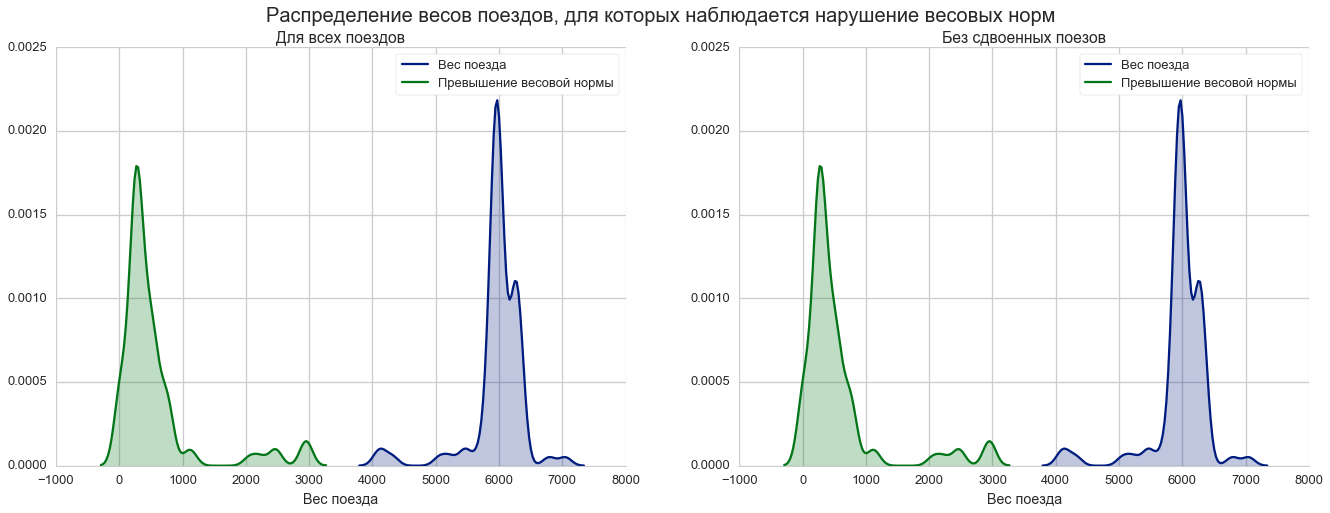

In [74]:
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.distplot(overweight_plan.train_weight, hist=False, color='b', 
             kde_kws={'shade':True, 'label':'Вес поезда'}, ax=ax[0])
sns.distplot(overweight_plan.overweight, hist=False, color='g', 
             kde_kws={'shade':True, 'label':'Превышение весовой нормы'}, ax=ax[0])
sns.distplot(overweight_no_joint.train_weight, hist=False, color='b', 
             kde_kws={'shade':True, 'label':'Вес поезда'}, ax=ax[1])
sns.distplot(overweight_no_joint.overweight, hist=False, color='g', 
             kde_kws={'shade':True, 'label':'Превышение весовой нормы'}, ax=ax[1])
title = 'Для всех поездов'
title_nj = 'Без сдвоенных поезов'
ax[0].set(title=title, xlabel='Вес поезда')
ax[1].set(title=title_nj, xlabel='Вес поезда')
ax[0].legend(frameon=True)
ax[1].legend(frameon=True)
plt.suptitle('Распределение весов поездов, для которых наблюдается нарушение весовых норм', fontsize=20)
sns.despine()
filename = 'weight_error.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [75]:
add_header('Распределение нарушений весовых норм по участкам (первые 5):')
a = overweight_no_joint.link_name.value_counts()
b = overweight_no_joint.groupby('link_name').overweight.median()
overweight_links = a.to_frame().join(b)
overweight_links.columns = ['number', 'overw_median']
pd.set_option('display.max_colwidth', 50)
add_line(overweight_links.reset_index().head())

add_header('\nРаспределение нарушений весовых норм по сериям локомотивов:')
a = overweight_no_joint.ser_name.value_counts()
b = overweight_no_joint.groupby('ser_name').overweight.median()
overweight_ser = a.to_frame().join(b)
overweight_ser.columns = ['number', 'overw_median']
add_line(overweight_ser.reset_index())

Распределение нарушений весовых норм по участкам (первые 5):
                            index  number  overw_median
               (ТУРГУТУЙ, ЛЕСНАЯ)      60         313.5
 (КОРШУНИХА-АНГАРСКАЯ, ХРЕБТОВАЯ)       3        2489.0
                 (БОРЗЯ, ХАРАНОР)       2         265.5
                   (ТУРМА, ТОРЕЯ)       2        2597.5
                 (МОГОЧА, АМАЗАР)       1           5.0

Распределение нарушений весовых норм по сериям локомотивов:
   index  number  overw_median
    ВЛ85      37         284.0
   3ЭС5К      16         264.0
   ВЛ80Р      14         501.0
   ВЛ80С       8         495.5
  ВЛ80ТК       4        1655.5
 3ТЭ10МК       2         265.5


<a =id='change'></a>
## Проверка смены локомотивов на станциях обязательной смены [ToC](#toc)

In [76]:
add_header('Проверка смены локомотивов на станциях обязательной смены', h=2, p=False)

In [77]:
hor = 24 * 3600
cols = ['train', 'st_from_name', 'st_to_name', 'time_start_norm', 'loco', 'train_start', 'loco_start']
train_plan['train_start'] = train_plan.train != train_plan.train.shift(1)
train_plan['loco_start'] = (train_plan.loco != train_plan.loco.shift(1)) & (train_plan.loco.isnull() == False)
loco_changes = train_plan.loc[(train_plan.train_start == False) & (train_plan.loco_start == True) &
              (train_plan.time_start < current_time + hor)]
add_header('Станции смены локомотивов (показаны первые 10):')
add_line(loco_changes.st_from_name.value_counts().head(10))

Станции смены локомотивов (показаны первые 10):
СМОЛЯНИНОВО      1
ВОЛОЧАЕВКА II    1
БОРЗЯ            1
КАРЫМСКАЯ        1


In [78]:
# Список станций (первый столбец), на которых локомотивы меняются всегда,
# если в машруте поезда есть любая из проверочных станций (второй столбец)
st_list = [['КАРЫМСКАЯ',['УРУЛЬГА']], ['БОРЗЯ',['ХАРАНОР','ЗУН-ТОРЕЙ']], ['ТАКСИМО', ['КУАНДА','КАЗАНКАН']], 
           ['СКОВОРОДИНО', ['ШТУРМ']], ['ИЗВЕСТКОВАЯ', ['КУЛЬДУР']], ['ВОЛОЧАЕВКА II', ['СЕЛЬГОН']], 
           ['УССУРИЙСК', ['ПРИМОРСКАЯ', 'ГРОДЕКОВО']]]
df_list = pd.DataFrame(st_list, columns=['st', 'other_st'])
pd.set_option('display.max_colwidth', 50)
add_header('Станции обязательной смены локомотивов:')
add_line(df_list)
a = train_plan.groupby('train').st_from_name.unique().to_frame()
a.columns = ['route']
train_plan['route'] = train_plan.train.map(a.route)
# Если проверочная станция находится в маршруте поезда, значит, поезд едет в том направлении, где НАДО менять локомотив
train_plan['check_st'] = train_plan.st_from_name.map(df_list.set_index('st').other_st)
train_plan['in_route'] = train_plan.route.combine(train_plan.check_st, \
                                                  lambda x, y: not False in [st in x for st in y] if type(y) == list else False)

cols = ['train', 'st_from_name', 'st_to_name', 'time_start_norm', 'loco', 'in_route']
change_fails = train_plan.loc[(train_plan.time_start < current_time + hor) 
                              & (train_plan.train_type.isin([2, 9]))
                              & (train_plan.train_start == False)
                              & (train_plan.loco_start == False)
                              & (train_plan.st_from_name.isin(df_list.st))
                              & (train_plan.in_route == True)][cols].drop_duplicates().dropna(subset=['loco'])
add_header('\nВсего %d поездов, у которых должна быть смена локомотивов на станциях обязательной смены, но она не запланирована:' 
      % len(change_fails))
add_line(change_fails.sort_values(['st_to_name', 'time_start_norm']))

Станции обязательной смены локомотивов:
            st                 other_st
     КАРЫМСКАЯ                [УРУЛЬГА]
         БОРЗЯ     [ХАРАНОР, ЗУН-ТОРЕЙ]
       ТАКСИМО       [КУАНДА, КАЗАНКАН]
   СКОВОРОДИНО                  [ШТУРМ]
   ИЗВЕСТКОВАЯ                [КУЛЬДУР]
 ВОЛОЧАЕВКА II                [СЕЛЬГОН]
     УССУРИЙСК  [ПРИМОРСКАЯ, ГРОДЕКОВО]

Всего 8 поездов, у которых должна быть смена локомотивов на станциях обязательной смены, но она не запланирована:
        train st_from_name st_to_name time_start_norm          loco in_route
 200021129391  ИЗВЕСТКОВАЯ    ОБЛУЧЬЕ   Jul 15, 18:48  200200061727     True
 220210232131    КАРЫМСКАЯ    ТАРСКАЯ   Jul 15, 20:02  200200056933     True
 200020077987    КАРЫМСКАЯ    ТАРСКАЯ   Jul 16, 06:55  200200086778     True
 200020313309    КАРЫМСКАЯ     ЧИТА I   Jul 15, 19:10  200200091591     True
 200020231500    КАРЫМСКАЯ     ЧИТА I   Jul 15, 19:15  200200092864     True
 200020116816    КАРЫМСКАЯ     ЧИТА I   Jul 16, 01:22  20020008

<a =id='res'></a>
## Анализ локомотивов резервом [ToC](#toc)

In [79]:
add_header('Анализ локомотивов резервом', h=2, p=False)
hor = 24 * 3600
add_line('Анализируемый горизонт отправления: %.2f ч.' % (hor / 3600))

Анализируемый горизонт отправления: 24.00 ч.


<a =id='res_nums'></a>
### Проверка диапазона номеров для локомотивов резервом [ToC](#toc)

In [80]:
train_plan.columns
train_plan['train_type'] = train_plan.train.apply(lambda x: int(str(x)[0]))
train_plan['res_train_num'] = train_plan.train.apply(lambda x: int(str(x)[-4:]))
res_train_nums = train_plan[train_plan.train_type == 8].res_train_num.drop_duplicates()
add_line('Диапазон номеров поездов для локомотивов резервом: от %d до %d' % (res_train_nums.min(), res_train_nums.max()))

Диапазон номеров поездов для локомотивов резервом: от 4201 до 4897


<a =id='res_amount'></a>
### Анализ количества отправлений локомотивов резервом по направлениям [ToC](#toc)

In [85]:
loco_mask = loco_plan.time_start < current_time + hor
loco_cols = ['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'time_start_norm', 'time_end_norm',
             'state', 'train', 'res_start', 'res_end']
loco_plan['res_start'] = loco_plan.train != loco_plan.train.shift(1)
loco_plan['res_end'] = loco_plan.train != loco_plan.train.shift(-1)
loco_plan.loc[loco_plan.state == 0, loco_cols]
loco_res_start = loco_plan.loc[(loco_plan.res_start == True) &
                               (loco_plan.state == 0), loco_cols].sort_values(['loco', 'time_start'])
loco_res_end = loco_plan.loc[(loco_plan.res_end == True) 
                             & (loco_plan.state == 0), loco_cols].sort_values(['loco', 'time_start'])
cols = ['loco', 'st_from_name', 'st_to_name', 'st_to_name_end', 'time_start', 'time_start_norm', 'time_end', 'time_end_norm', 'train']
loco_res_trips = loco_res_start[['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_start_norm', 'train']].\
                set_index(['loco', 'train']).join(loco_res_end[['loco', 'st_to_name', 'time_end', 'time_end_norm', 'train']].\
                                                  set_index(['loco', 'train']), rsuffix='_end').reset_index()[cols]

loco_res_trips_hor = loco_res_trips.loc[loco_res_trips.time_start < current_time + hor]
add_line('Всего отправок локомотивов резервом: %d' % loco_res_trips_hor.loco.count())
add_line('Всего локомотивов, для которых есть пересылка резервом: %d' % loco_res_trips_hor.loco.drop_duplicates().count())
add_header('\nСтанции, с которых было отправлено больше всего локомотивов резервом (первые 10):')
add_line(loco_res_trips_hor.st_from_name.value_counts().head(10))
add_header('\nУчастки планирования, на которых было отправлено больше всего локомотивов резервом (первые 10):')
add_line(loco_res_trips_hor.groupby('st_from_name').st_to_name.value_counts().sort_values(ascending=False).head(10))
add_header('\nСамые частые маршруты для локомотивов резервом (первые 10):')
add_line(loco_res_trips_hor.groupby('st_from_name').st_to_name_end.value_counts().sort_values(ascending=False).head(10))

Всего отправок локомотивов резервом: 355
Всего локомотивов, для которых есть пересылка резервом: 283

Станции, с которых было отправлено больше всего локомотивов резервом (первые 10):
БИРА                     36
БОЛЬШОЙ ЛУГ              19
ПЕТРОВСКИЙ ЗАВОД         10
КАДАЛА                   10
ГОРХОН                    9
ГОРЕЛЫЙ                   8
УЛАН-УДЭ                  8
БЕРКАКИТ                  7
ЧЕЛУТАЙ                   7
ИРКУТСК-СОРТИРОВОЧНЫЙ     7

Участки планирования, на которых было отправлено больше всего локомотивов резервом (первые 10):
st_from_name                        st_to_name          
БИРА                                ИЗВЕСТКОВАЯ             36
БОЛЬШОЙ ЛУГ                         ГОНЧАРОВО               19
КАДАЛА                              ЧИТА I                  10
ГОРХОН                              КИЖА                     9
ГОРЕЛЫЙ                             СКОВОРОДИНО              8
БЕРКАКИТ                            БЕСТУЖЕВО                7
ЧЕЛУ

<a =id='res_before'></a>
### Локомотивы резервом до начала планирования [ToC](#toc)

In [86]:
add_info(links)
add_line('Время начала планирования: %s (%d)' % (time.strftime(time_format, time.localtime(current_time)), current_time))
loco_res_trips['link_name'] = list(zip(loco_res_trips.st_from_name, loco_res_trips.st_to_name))
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
loco_res_trips['dir'] = loco_res_trips.link_name.map(links.drop_duplicates('link_name').set_index('link_name')['dir'])
loco_res_trips_hor = loco_res_trips.loc[loco_res_trips.time_start < current_time + hor]
    
cols = ['loco', 'st_from_name', 'st_to_name_end', 'time_start', 'time_start_norm', 'dir', 'train']
res_before_ct = loco_res_trips.loc[loco_res_trips.time_start < current_time, cols]
add_header('Всего %d локомотивов, отправленных резервом до начала планирования (показаны первые 10):' % len(res_before_ct.index))
if not res_before_ct.empty:
    add_line(res_before_ct.sort_values('time_start').head(10))

Время начала планирования: Jul 15, 14:41 (1468582897)
Всего 0 локомотивов, отправленных резервом до начала планирования (показаны первые 10):


<a =id='res_even'></a>
### Локомотивы резервом в четном направлении [ToC](#toc)

In [87]:
cols = ['loco', 'st_from_name', 'st_to_name_end', 'time_start', 'time_start_norm', 'dir', 'train']
even_res = loco_res_trips.loc[loco_res_trips.dir == 0, cols]
even_res_hor = loco_res_trips_hor.loc[loco_res_trips_hor.dir == 0, cols]
a = even_res_hor.groupby('st_from_name').st_to_name_end.value_counts().sort_values(ascending=False)
add_header('Самые частые маршруты для локомотивов резервом в четном направлении (всего %d, показаны первые 10):' 
      % even_res_hor.loco.drop_duplicates().count())
add_line(a.head(10))

st_from = a.to_frame().reset_index().ix[0]['st_from_name']
st_to = a.to_frame().reset_index().ix[0]['st_to_name_end']
most_even_res = even_res_hor.loc[(even_res_hor.st_from_name == st_from) 
                                 & (even_res_hor.st_to_name_end == st_to)].sort_values('time_start')
add_header('\nЛокомотивы резервом на самом частном маршруте в четном направлении:')
add_line(most_even_res)

Самые частые маршруты для локомотивов резервом в четном направлении (всего 125, показаны первые 10):
st_from_name                        st_to_name_end                    
ГОРХОН                              ПЕТРОВСКИЙ ЗАВОД                      9
ГОРЕЛЫЙ                             СКОВОРОДИНО                           8
КАДАЛА                              ЧИТА I                                8
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  ДЗЕМГИ                                5
ВОЛОЧАЕВКА I                        ВОЛОЧАЕВКА II                         5
ХАНИ                                ТЫНДА                                 4
ЧИТА I                              ШАХТЕРСКАЯ                            3
ЧЕРЕМХОВО                           ИРКУТСК-СОРТИРОВОЧНЫЙ                 3
ГРОДЕКОВО (КИТАЙ)                   ГРОДЕКОВО                             3
ПОСТЫШЕВО                           КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ    3

Локомотивы резервом на самом частном маршруте в четном направлении:

[В начало](#toc)
### Проверка времени хода для локомотивов резервом

In [148]:
def get_regions(x):
    return list(a[a.apply(lambda y: (x[0] in y) & (x[1] in y))].index)

a = stations.groupby('loco_region')['name'].unique()
loco_res_trips['reg'] = loco_res_trips.link_name.apply(get_regions)
loco_res_trips['loco_reg'] = loco_res_trips.loco.map(loco_info.set_index('loco').regions_eval)
loco_res_trips['back_to_reg'] = loco_res_trips.apply(lambda row:\
                                                     not any([int(r) in [int(x) for x in row.loco_reg] for r in row.reg]),
                                                     axis=1)
loco_res_trips['tt'] = loco_res_trips.time_end - loco_res_trips.time_start
loco_res_trips['tt_h'] = np.round((loco_res_trips.tt / 3600), 2)
cols = ['loco', 'st_from_name', 'st_to_name_end', 'time_start_norm', 'time_end_norm', 'tt_h']
res_trips_long = loco_res_trips[loco_res_trips.tt > 15 * 3600].sort_values('tt_h', ascending=False)
add_header('Всего %d (%.2f%%) пересылок локомотивов резервом с временем хода больше 15 часов' 
           % (res_trips_long.loco.count(), 100 * res_trips_long.loco.count() / loco_res_trips.loco.count()))
res_trips_long_no_back = res_trips_long[res_trips_long.back_to_reg == False]
add_header('Из них %d НЕ являются возвратом на свое тяговое плечо. Примеры:' 
           % res_trips_long_no_back.loco.count())
add_line(res_trips_long_no_back.head(10)[cols])
loco_id = res_trips_long_no_back.iloc[0].loco
plan_cols = ['loco', 'ser_name', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'train']
add_line(loco_plan[loco_plan.loco == loco_id][plan_cols])
add_header('Среднее время хода для таких локомотивов: %.2f ч.' % res_trips_long_no_back.tt_h.mean())

Всего 50 (8.49%) пересылок локомотивов резервом с временем хода больше 15 часов
Из них 15 НЕ являются возвратом на свое тяговое плечо. Примеры:
         loco      st_from_name         st_to_name_end time_start_norm  time_end_norm   tt_h
 200200047018  ПЕТРОВСКИЙ ЗАВОД              КАРЫМСКАЯ   Jul 15, 19:18  Jul 16, 17:23  22.09
 200200082067       СМОЛЯНИНОВО          ВОЛОЧАЕВКА II   Jul 16, 11:40  Jul 17, 05:17  17.62
 200200102812            МОГОЧА              МАГДАГАЧИ   Jul 16, 08:17  Jul 17, 01:27  17.17
 200200045126         КАРЫМСКАЯ                ЧЕЛУТАЙ   Jul 16, 02:49  Jul 16, 19:47  16.96
 200207612088              ЛЕНА                 ТАЙШЕТ   Jul 16, 18:15  Jul 17, 11:03  16.81
 200200105990       СКОВОРОДИНО      НЕРЮНГРИ-ГРУЗОВАЯ   Jul 17, 00:07  Jul 17, 16:41  16.57
 200200103181              ЗИМА                БАЗАИХА   Jul 16, 23:05  Jul 17, 15:34  16.49
 200200103406            ЧИТА I                ЧЕЛУТАЙ   Jul 15, 22:48  Jul 16, 15:17  16.47
 200200099359      

### Причины появления четных локомотивов резервом:

1. Мариинск и Карымская не являются станциями прохождения ТО. Поэтому локомотивы пересылаются резервом из Мариинска в Боготол для прохождения ТО или из Читы на Карымскую после прохождения ТО в Чите для подвязки под поезда в Карымской. Необходимо обновить справочник ПТОЛ.
2. У локомотивов среди разрешенных тяговых плеч указаны и Мариинск-Борзя, и Карымская-Хабаровск. Поэтому локомотивы едут резервом из Читы в Карымскую, чтобы везти локомотивы на Хабаровск, поскольку Чита совсем недалеко от Карымской. Если бы у локомотивов с плеча Мариинск-Борзя не было проставлено плечо Карымская-Хабаровск, то направления резервом из Читы не было бы. Необходимо загрузить новый справочник тяговых плеч, где такого не будет.
3. Поезда своего формирования (ССП) из Карымской следуют только до Читы. Поэтому локомотивы и освобождаются в Чите. Но поскольку в Чите они не нужны, то следуют резервом "куда-то, где нужны". В новом справочнике от Войтенко поезда СФ из Карымской следуют до Иркутска, Челутая и Петровского Завода -- это дальше Читы. Поэтому отправлений резервом из Читы станет меньше. Аналогичная проблема: для поездов СФ из Красноярска-Восточного и Тайшета.
4. Недостаточное количество поездов в четном направлении на главном ходу -- поэтому локомотивы, которые могли бы ехать в четную сторону с поездами, едут резервом. Будет исправлено с загрузкой новых маршрутов.
5. Смена локомотивов происходит на станции Горелый (для маршрутов типа Карымская--Беркакит или Таксимо--Карымская, например). Хотя поезд правильнее заводить на Сковородино и менять локомотив там. Проблема в том, что тогда на маршруте поезда получится петля типа "Бамовская -- Горелый -- Сковородино -- Горелый -- Штурм". Текущий алгоритм построения маршрутов не сможет сгенерировать такой маршрут у поезда. Видимо, нужна более продвинутая проверка на приоритетные станции при смене локомотивов и корректировка маршрута поезда. Сложная проблема, надо думать. Пока отложено до 10.05.2016.
6. Узел Комсомольска-на-Амуре сложный, надо разбираться. Возможно, надо будет вводить дополнительный участок планирования КнА II - КнА-Сорт. Тоже сложная проблема, тоже пока отложено до 10.05.2016.

<a id='time_leaps'></a>
## Проверка скачков по времени назад [ToC](#toc)

In [ ]:
add_header('Проверка скачков по времени назад', h=2, p=False)

In [ ]:
loco_plan['next_time_start'] = loco_plan.time_start.shift(-1)
loco_plan['next_time_start_norm'] = loco_plan.time_start_norm.shift(-1)
loco_plan['loco_end'] = loco_plan.loco != loco_plan.loco.shift(-1)
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'next_time_start_norm']
leaps = loco_plan[(loco_plan.loco_end == False) & (loco_plan.next_time_start < loco_plan.time_end)]
if leaps.empty:
    add_header('Не найдено локомотивов со скачками по времени назад в плане')
else:
    add_header('Всего %d локомотивов со скачками по времени назад в плане. Примеры:' % leaps.loco.count())
    add_line(leaps.head(10)[cols])

<a id='report'></a>
### Экспорт результатов в HTML [ToC](#toc)

In [ ]:
filename = REPORT_FOLDER + 'loco_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)